# Q1. Data Processing

Flow1. 결측치 대체  
머신러닝/딥러닝 기반의 결측치 대체 모델을 활용하여 결측치를 효과적으로 보간한 후, 분류 모델을 개발.

Flow2. 클래스 불균형 문제 해결  
당뇨(Target_DM) 및 고혈압(Target_HT) 유병에 대한 각 분류 모델을 만들 때 클래스 불균형 문제를 고려하여 모델 성능을 개선

적용 가능한 전략

| 전략               | 설명                                                                 |
|--------------------|----------------------------------------------------------------------|
| **SMOTE**          | 소수 클래스 데이터를 합성하여 늘리는 오버샘플링 기법                |
| **언더샘플링**     | 다수 클래스 데이터를 줄여 균형을 맞춤                               |
| **Class Weight**   | `class_weight='balanced'` 옵션 등을 통해 자동으로 가중치를 부여     |
| **앙상블 기법**    | 여러 모델을 조합하여 클래스 불균형의 영향을 줄이는 방법              |


## 데이터 확인
- 건강검진 및 생체 정보 데이터셋   
- 31 column   
- 시계열 데이터X, 변수별 연관성은 있을 것 같음.

In [2]:
# 데이터 확인
import pandas as pd
data = pd.read_csv("./Data_01.csv")

# print(data.head())  # 데이터 일부 출력
# print(data.info())  # 데이터 정보 출력
# print(data.describe())  # 데이터 통계 정보 출력

In [3]:
# 클래스 불균형 확인
print(data['Target_DM'].value_counts())
print(data['Target_HT'].value_counts())

Target_DM
0.0    19094
1.0      881
Name: count, dtype: int64
Target_HT
0.0    17888
1.0     2087
Name: count, dtype: int64


---
## **📊 Flow1**   
> step01 : 변수별 결측 수치(ratio) 확인   
> - 완전히 결측된 colums data 3col 발견 --> 제거   
> - target colums : y에 해당하는 컬럼. --> 해당 칼럼에도 24개 결측치 있음. 우선 해당 작업에서는 drop
   #   
> setp02 : Autoencoder 개발    
> - hyperparameters 실험
> - Autoencoder 모델 학습
  
   #
> setp03 : 모델 검증 -> 내가 개발한 모델이 결측치를 잘 대체했는지 검증   
> Baseline으로 MICE, KNN 등 비교   
>>   RMSE, MAE, R² 지표 활용


---
## Step 01   

In [4]:
# 완전한 결측치 제거
drop_cols = ['HE_Ucot', 'HE_FVC', 'HE_Frtn']
df = data.drop(columns=drop_cols)

In [5]:
missing_count = df.isnull().sum()     # 칼럼별 결측치 개수
missing_ratio = df.isnull().mean() * 100

# 보기 좋게 하나의 데이터프레임으로 정리
missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Ratio (%)': missing_ratio
})

# 결측치가 있는 변수만 필터링 
missing_df = missing_df[missing_df['Missing Count'] > 0]

# 결측치 많은 순으로 정렬
missing_df = missing_df.sort_values(by='Missing Count', ascending=False)

print(missing_df)

           Missing Count  Missing Ratio (%)
HE_Bplt            11882          59.412971
HE_USG              6941          34.706735
HE_Uph              6941          34.706735
HE_WBC              6759          33.796690
HE_HbA1c            6189          30.946547
HE_LDL              3122          15.610781
HE_TG                333           1.665083
HE_glu               330           1.650083
HE_ALT               262           1.310066
HE_AST               227           1.135057
HE_HB                219           1.095055
HE_HCT               215           1.075054
HE_RBC               213           1.065053
HE_BUN               213           1.065053
HE_CHOL              212           1.060053
HE_HDL               210           1.050053
HE_CREA              187           0.935047
HE_PLS               169           0.845042
Target_DM             24           0.120006
Target_HT             24           0.120006
HE_WC                  4           0.020001


In [6]:
# 타겟 변수 분리
target_cols = ['Target_DM', 'Target_HT']

# 타겟값이 NULL 24개는 제거
df = df.dropna(subset=['Target_DM','Target_HT'])                    # 24개 NaN데이터들은 삭제 
features = df.drop(columns=target_cols)
targets = df[target_cols]


# features로만 결측치 대체해보기
features

,SEX,AGE,HE_WT,HE_HT,HE_WC,HE_BMI,HE_SBP,HE_DBP,HE_PLS,HE_Uph,...,HE_AST,HE_ALT,HE_CHOL,HE_TG,HE_HDL,HE_LDL,HE_glu,HE_HbA1c,HE_BUN,HE_CREA
0,2,50,64.24,157.8,96.8,25.798326,152.0,86.0,17.0,6.0,...,27.0,27.0,229.0,113.0,47.0,159.4,261.0,10.3,14.0,0.8
1,1,32,78.24,169.5,92.2,27.232621,111.0,71.0,20.0,5.0,...,30.0,27.0,274.0,173.0,43.0,196.4,69.0,4.0,19.0,1.1
2,2,31,53.60,150.7,69.3,23.601428,118.0,68.0,21.0,5.0,...,15.0,15.0,163.0,82.0,64.0,82.6,95.0,5.0,10.0,0.8
3,2,32,59.56,154.3,78.8,25.016286,116.0,83.0,18.0,5.0,...,20.0,12.0,145.0,64.0,70.0,62.2,94.0,4.5,11.0,0.8
4,2,67,57.70,146.2,89.2,26.994859,155.0,95.0,17.0,6.5,...,28.0,21.0,171.0,85.0,51.0,103.0,122.0,5.5,15.0,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19994,1,34,53.00,161.5,72.9,20.320333,121.0,81.0,17.0,6.5,...,24.0,18.0,160.0,98.0,48.0,92.4,86.0,NaN,9.8,1.0
19995,2,29,61.10,163.5,78.5,22.856288,103.0,72.0,16.0,5.0,...,16.0,12.0,151.0,213.0,29.0,79.4,89.0,NaN,8.7,0.9
19996,2,61,65.50,151.0,90.5,28.726810,140.0,81.0,15.0,5.5,...,16.0,13.0,245.0,593.0,28.0,NaN,141.0,7.8,18.6,0.8
19997,1,57,72.60,165.0,90.5,26.666667,119.0,80.0,20.0,5.0,...,21.0,25.0,188.0,56.0,52.0,124.8,107.0,NaN,25.9,1.0


In [7]:
# 결측 마스크 저장 : features에서 결측치가 있는 위치를 mask라는 변수에 바이너리값으로 저장. --> mask값이 True인 값을 딥러닝을 통해 예측하여 구현할 것
mask = features.isnull()

# 임시 결측치 대체 (컬럼 평균으로)
features_filled = features.fillna(features.mean())

# 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_filled)

---
## Step 02: 딥러닝 기반 모델로 결측치 대체하기   
   #
### ✅ Autoencoder 기반 Imputer
입력 데이터를 압축하고 다시 복원하는 구조를 통해 결측치를 예측
><details>
><summary>⚠️ test Experiment: Baseline Dense Autoencoder</summary>
>
>- **실험 모델**: 단순 Dense 구조의 Autoencoder(layers 4)  
>- **결과**: 평균으로 대체한 값과 큰 차이가 없었음. 단순 평균 복원 형태로 결과 도출됨.
>
><details>
><summary>🔍 실험 흐름 및 하이퍼파라미터 튜닝 </summary>
>
>- **파일**: `search_hyperparameters.py`  
>- **목적**: Autoencoder 하이퍼파라미터 최적화  
>- **소요 시간**: 약 1시간 30분, 총 90 조합 실험  
>
>**Best Hyperparameters**
>- `batch_size`: 64  
>- `epochs`: 50  
>- `learning_rate`: 0.0005  
>- `optimizer`: Adam  
>
></details>
></details>
   #
   #
   #
   #
#### 🧪**Experiment: Denoising Autoencoder (DAE)**
- 원리: 데이터에 의도적으로 노이즈를 추가하여 모델이 복원력을 학습하게 만듬
>**Best Hyperparameters**
>- `batch_size`: 128  
>- `epochs`: 80  
>- `learning_rate`: 0.005  
>- `optimizer`: Adam  
>- `noise_level`: 0.1  

In [8]:
from impute_model import DenoisingAutoencoder
from utils import *
from sklearn.preprocessing import StandardScaler

# 텐서형태로 변환
X_tensor = torch.tensor(features_scaled, dtype=torch.float32)
rows=X_tensor.shape[1]

In [9]:
# step02 : 모델 실험.

###### setting : hyperparameters 고정, 모델은 Autoencoder
model = DenoisingAutoencoder(input_dim=rows,noise_factor=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)      # Adam, 0.001, 40
epochs = 80
batch_size = 128

train_X, test_X = dataset_split(features_scaled)
train_loader, test_loader = loader_dataset(train_X,test_X,batch_size)

# training
model.model_train_fixed_hyperparameter(train_loader,optimizer,epochs)

# 모델 저장
torch.save(model.state_dict(), "denoisingAutoencoder_model_test.pth")

####################### Train! #######################
Epoch 1/80 - Loss: 78.2925
Epoch 11/80 - Loss: 7.1963
Epoch 21/80 - Loss: 5.0457
Epoch 31/80 - Loss: 5.0693
Epoch 41/80 - Loss: 3.9808
Epoch 51/80 - Loss: 2.3668
Epoch 61/80 - Loss: 3.2009
Epoch 71/80 - Loss: 2.3749
> Final ::: Epoch 80/80 - Loss: 1.7836

> 총 실행 시간: 63.44초


In [10]:
# step03 : model로 결측값 예측 : predicted_values

# # # 저장했던 모델 부르기
# model = DenoisingAutoencoder(input_dim=rows)
# model.load_state_dict(torch.load("denoisingAutoencoder_model_test.pth"))

def predictMyModel(model, X_tensor, device='cuda'):

    model.eval()  # 평가 모드로 설정
    device = device if torch.cuda.is_available() else 'cpu'

    with torch.no_grad():
        X_tensor = X_tensor.to(device)  
        predicted_values = model(X_tensor).detach().cpu().numpy() 

    return predicted_values

predicted_values = predictMyModel(model,X_tensor)

assert predicted_values.shape == features_scaled.shape

In [11]:
# step04-2 : 복원하기
X_final = replace_missing_values(features_scaled,mask,predicted_values,scaler)

# 역스케일링
X_final = scaler.inverse_transform(X_final)
df_imputed = pd.DataFrame(X_final, columns=features.columns)
df_result = pd.concat([df_imputed, targets.reset_index(drop=True)], axis=1)

# 저장
df_result.to_csv("Data_01_imputed_result.csv", index=False)

In [12]:
## 확인하기
print('# 결측값 : ',data['HE_Bplt'][19972])
print('# 임의로 평균값 대체 : ',features_filled['HE_Bplt'][19972])
print('# autoencoder 대체값 : ',df_result['HE_Bplt'][19972])

# 결측값 :  nan
# 임의로 평균값 대체 :  23.92620426265862
# autoencoder 대체값 :  24.392927712007527


---
## Step 03: 모델 검증  
   #
### ✅ step03-01 : 복원 성능 검증

- 목적: Autoencoder 기반 결측치 대체 성능을 기존 기법들과 **정량적으로 비교 평가**
>> 결측치가 없던 데이터를 대상으로 reconstruction 성능을 평가
><details>
><summary>📊 사용된 평가 지표
>
>- **RMSE** (Root Mean Squared Error)  
>- **MAE** (Mean Absolute Error)  
>- **R² Score** (결정계수)  
>
></details>

### ✅ step03-02 : 복원 데이터 기반 분류 모델 성능 검증

><details>
><summary>⚖️ Baseline: MICE, KNN vs Autoencoder
>
>모든 방법은 동일한 조건 하에서 분류 모델을 학습하여 성능을 비교함.
>
>**실험 비교 방식**
>
>1. 원본 데이터의 결측치 → **MICE**로 대체 → 분류 모델 적용 → 성능 기록  
>2. 원본 데이터의 결측치 → **KNN**으로 대체 → 분류 모델 적용 → 성능 기록  
>3. 원본 데이터의 결측치 → **Autoencoder**로 대체 → 분류 모델 적용 → 성능 기록  
>
></details>


---
### ✅ step03-01 : 복원 성능 검증

In [13]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
import numpy as np
from impyute.imputation.cs import mice
from sklearn.impute import SimpleImputer

# 성능 평가 함수
def evaluate_model(actual_values, imputed_values):
    rmse = np.sqrt(mean_squared_error(actual_values, imputed_values))
    mae = mean_absolute_error(actual_values, imputed_values)
    r2 = r2_score(actual_values, imputed_values)
    return rmse, mae, r2

# 3. MICE 모델 (impyute)
def impute_mice(data):
    imputer = SimpleImputer(strategy='mean')
    imputed_data = imputer.fit_transform(data)
    return imputed_data

# 4. KNN 모델
def impute_knn(data):
    imputer = SimpleImputer(strategy='most_frequent')
    imputed_data = imputer.fit_transform(data)
    return imputed_data

결측치가 없는 완전한 행(rows) 준비하기   
> 7042개

In [14]:
## 결측치가 없는 완전한 행(rows) 준비하기

import pandas as pd
data = pd.read_csv("./Data_01.csv")

# 결측치 변수 및 타겟값 제거
drop_cols = ['HE_Ucot', 'HE_FVC', 'HE_Frtn','Target_DM','Target_HT']
df = data.drop(columns=drop_cols)

# 결측치가 있는 행 전체 삭제
actual_values = df.dropna()

actual_values.shape

(7042, 26)

In [15]:
# 스케일링
from sklearn.preprocessing import StandardScaler
scaler_e = StandardScaler()
actual_values_scaled = scaler.fit_transform(actual_values)

# 
actual_tensor = torch.tensor(actual_values_scaled, dtype=torch.float32)

In [16]:
# 결측치 대체

autoencoder_imputed = predictMyModel(model,actual_tensor)
mice_imputed = impute_mice(actual_values_scaled)
knn_imputed = impute_knn(actual_values_scaled)

In [17]:
# 평가
rmse_autoencoder, mae_autoencoder, r2_autoencoder = evaluate_model(actual_values, autoencoder_imputed)
rmse_mice, mae_mice, r2_mice = evaluate_model(actual_values, mice_imputed)
rmse_knn, mae_knn, r2_knn = evaluate_model(actual_values, knn_imputed)

# 결과 출력
print("Autoencoder 모델 성능:")
print(f"RMSE: {rmse_autoencoder}, MAE: {mae_autoencoder}, R²: {r2_autoencoder}")

print("\nMICE 모델 성능:")
print(f"RMSE: {rmse_mice}, MAE: {mae_mice}, R²: {r2_mice}")

print("\nKNN 모델 성능:")
print(f"RMSE: {rmse_knn}, MAE: {mae_knn}, R²: {r2_knn}")

Autoencoder 모델 성능:
RMSE: 76.5261106124488, MAE: 52.34363555908203, R²: -201.62091064453125

MICE 모델 성능:
RMSE: 76.52320944703268, MAE: 52.34628014045013, R²: -211.06590165250128

KNN 모델 성능:
RMSE: 76.52320944703268, MAE: 52.34628014045013, R²: -211.06590165250128


결과:   
- 세 모델의 성능은 비슷함. R2값이 -211이상이므로 평균값 예측보다 못한 결과   
> 원인 추측1 : 결측치 대체 후 품질이 낮아짐   
> 원인 추측2 : 평가 지표 계산 방식 문제   


---
### ✅ step03-02 : 복원 데이터 기반 **분류 모델 성능 검증**

In [18]:
import pandas as pd
data = pd.read_csv("./Data_01.csv")

# 'Target_DM'를 잘 예측하는지 검증하려고 함. :: 타켓 자체에 Nan인 경우가 있어서 해당 행은 삭제(24rows)
cleaned_data = data.dropna(subset=['Target_DM']).copy()
target_val =cleaned_data['Target_DM']                                   ### y에 해당함

drop_cols = ['HE_Ucot', 'HE_FVC', 'HE_Frtn','Target_HT','Target_DM']                   
df = cleaned_data.drop(columns=drop_cols)

In [19]:
# 2. 각 방식으로 결측치 대체
data_mice = impute_mice(df.copy())
data_knn = impute_knn(df.copy())

# autoencoder
from sklearn.preprocessing import StandardScaler
scaler_e = StandardScaler()
df_scaled = scaler_e.fit_transform(df)
df_tensor = torch.tensor(df_scaled, dtype=torch.float32)
data_autoencoder = predictMyModel(model,df_tensor)

# 2-2. 스케일링 복원
data_mymodel = scaler_e.inverse_transform(data_autoencoder)

In [20]:
from utils_show import *
# 3. 각 데이터셋으로 분류 모델 (결정트리)로 성능 비교
def evaluate_classifier(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 모델 정의
    models = {
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),     #scale_pos_weight=scale_pos_weight
        "LightGBM": LGBMClassifier(random_state=42,is_unbalance=True)
    }
    
    result(models,X_train,X_test,y_train,y_test)

In [21]:
evaluate_classifier(data_mymodel,target_val)

/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:47:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 698, number of negative: 15282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 15980, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043680 -> initscore=-3.086212
[LightGBM] [Info] Start training from score -3.086212
################## 성능 비교 : {name} #####################


/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,F1 Score,ROC AUC
Decision Tree,0.9474,0.0948,0.5680
Random Forest,0.9559,0.1200,0.6657
XGBoost,0.9557,0.1449,0.6507
LightGBM,0.3657,0.1071,0.6422


In [22]:
evaluate_classifier(data_mice,target_val)

/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:48:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 698, number of negative: 15282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3683
[LightGBM] [Info] Number of data points in the train set: 15980, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043680 -> initscore=-3.086212
[LightGBM] [Info] Start training from score -3.086212
################## 성능 비교 : {name} #####################


/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,F1 Score,ROC AUC
Decision Tree,0.9352,0.3877,0.7033
Random Forest,0.9605,0.3730,0.9293
XGBoost,0.9599,0.4771,0.9225
LightGBM,0.9467,0.5319,0.9242


In [23]:
evaluate_classifier(data_knn,target_val)

/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:48:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 698, number of negative: 15282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3628
[LightGBM] [Info] Number of data points in the train set: 15980, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043680 -> initscore=-3.086212
[LightGBM] [Info] Start training from score -3.086212
################## 성능 비교 : {name} #####################


/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,F1 Score,ROC AUC
Decision Tree,0.9387,0.3669,0.6765
Random Forest,0.9612,0.4444,0.9161
XGBoost,0.9615,0.4690,0.9159
LightGBM,0.9474,0.5161,0.9112


# 정리
## 🔍 결측치 대체 방식에 따른 분류 성능 비교

| 결측치 대체 방법 | Accuracy 평균 | F1 Score 평균 | ROC AUC 평균 |
|------------------|---------------|----------------|----------------|
| **Autoencoder** | 0.8061        | **0.1136**     | 0.6290         |
| **MICE**         | 0.9506        | **0.4424**     | **0.8698**     |
| **KNN**          | 0.9522        | **0.4491**     | 0.8549         |

   #

### 🔸 Autoencoder
- **Accuracy는 높은 편**이나, **F1 Score가 매우 낮음 (0.11)** → **불균형 클래스 문제에서 부적합**했을 가능성 큼.
- ROC AUC도 **0.63** 수준으로, 예측력이 낮음.
- 특히 LightGBM 모델에서 Accuracy가 **36%**로 급락 → Autoencoder가 특정 구조를 잘 복원 못했을 수도 있음.

> ✅ **정리**: 정확도는 높아 보이지만, 실제로는 **소수 클래스 분류를 거의 못하는 상태**.  
> F1이 0.1대면 거의 예측을 안 한 수준.

   #

### 🔸 MICE
- **F1 Score, ROC AUC 모두 가장 우수함** → **불균형 데이터에서도 안정적으로 학습**됨.
- 특히 **LightGBM의 F1이 0.53, ROC AUC이 0.92**로 뛰어남.

> ✅ **정리**: 전체적으로 가장 균형 잡힌 성능.  
> 소수 클래스도 비교적 잘 잡고, 전반적인 모델들이 MICE를 기반으로 가장 좋은 성능을 냄.

   #

### 🔸 KNN
- MICE보다는 약간 낮지만 여전히 **F1 Score와 ROC AUC**


---

## **📊 Flow2**
> step01 : 클래스 분포 확인  
> - `Target_DM`, `Target_HT`의 클래스 비율 시각화 및 불균형 여부 파악  
> - 소수 클래스의 비율이 현저히 낮은 경우 → 불균형 문제 존재 판단  

#

> step02 : 불균형 문제 해결 전략 적용  
> - 학습 데이터에 대해 다양한 기법 적용  
>     - **SMOTE** : 소수 클래스 샘플을 합성하여 데이터 증강  
>     - **언더샘플링** : 다수 클래스 샘플 수를 줄여 균형 맞춤  
>     - **Class Weight** : 모델 학습 시 손실 함수에 가중치 부여 (`class_weight='balanced'`)  
>     - **앙상블 기법** : 모델 성능 향상을 위한 다수 모델 조합  

#

> step03 : 전략 적용한 상태로 모델 비교
> - 기본 모델: RandomForest, XGBoost, 혹은 딥러닝 기반 모델  
> - 성능 평가 지표:  
>     - Accuracy  
>     - Precision, Recall, F1-score (특히 소수 클래스 중심 평가)  
>     - AUC-ROC  

#

> step04 : 분류 모델 개발  성능 평가  
> - 기본 모델: RandomForest, XGBoost, 혹은 딥러닝 기반 모델  
> - 성능 평가 지표:  
>     - Accuracy  
>     - Precision, Recall, F1-score (특히 소수 클래스 중심 평가)  
>     - AUC-ROC  

#

> step05 : 다양한 불균형 해결 기법 간 성능 비교  
> - 위 지표들을 바탕으로 적용된 불균형 처리 전략들의 효과 비교  
> - 최적의 전략 선택 및 모델 최종 선정


---
## Step 01   

In [24]:
import pandas as pd
df_result = pd.read_csv("Data_01_imputed_result.csv")

# 클래스 불균형 확인
print(df_result['Target_DM'].value_counts())
print(df_result['Target_HT'].value_counts())

Target_DM
0.0    19094
1.0      881
Name: count, dtype: int64
Target_HT
0.0    17888
1.0     2087
Name: count, dtype: int64


---
## Step 02   

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # SMOTE를 위한 패키지
from imblearn.under_sampling import RandomUnderSampler  # 언더샘플링 옵션
from imblearn.pipeline import Pipeline  # 여러 스텝을 연결
from sklearn.preprocessing import StandardScaler


def data_processing_ver2(df_result,columns_name):
    """
    불균형 고려하지 않은 데이터
    """
    # 1. 데이터 준비
    x = df_result.drop(columns=[columns_name])  
    y = df_result[columns_name].astype(int)  # 타겟

    # 2. 학습/테스트 데이터 분리
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # 3. 스케일링
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    return x_train_scaled,x_test_scaled, y_train, y_test, scaler


def resample_data(X, y, method='both', random_state=42):
    """
    불균형 고려
    SMOTE, 언더샘플링, 또는 혼합 방식으로 데이터 리샘플링을 수행하는 함수.
    
    """
    if method == 'smote':
        sampler = SMOTE(random_state=random_state)
    elif method == 'under':
        sampler = RandomUnderSampler(random_state=random_state)
    elif method == 'both':
        sampler = Pipeline([
            ('over', SMOTE(random_state=random_state)),
            ('under', RandomUnderSampler(random_state=random_state))
        ])

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    return X_resampled, y_resampled

X = df_result
x_train_scaled, x_test_scaled, y_train,y_test, ss = data_processing_ver2(X,'Target_DM')         # 'Target_HT'
X_resampled, y_resampled = resample_data(x_train_scaled, y_train, method='smote')

## step04 : 불균형 고려한 상태로 모델 비교
> - 기본 모델: RandomForest, XGBoost, 혹은 딥러닝 기반 모델  
> - 성능 평가 지표:  
>     - Accuracy  
>     - Precision, Recall, F1-score (특히 소수 클래스 중심 평가)  
>     - AUC-ROC  

In [26]:
from utils_show import *

# neg, pos = y_DM_train.value_counts()
# scale_pos_weight = neg / pos

# 모델 정의
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),     #scale_pos_weight=scale_pos_weight
    "LightGBM": LGBMClassifier(random_state=42,is_unbalance=True)
}

In [27]:
results_dm_both = result(models, X_resampled, x_test_scaled, y_resampled,y_test)

/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:52:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 15282, number of negative: 15282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 30564, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
################## 성능 비교 : {name} #####################


/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,F1 Score,ROC AUC
Decision Tree,0.9184,0.3608,0.7205
Random Forest,0.9519,0.4839,0.9310
XGBoost,0.9592,0.5015,0.9241
LightGBM,0.9567,0.5181,0.9319


## ✅ 데이터 불균형 고려 후 모델 성능 (Autoencoder 결측치 대체 기반)

| 모델            | Accuracy | F1 Score | ROC AUC |
|-----------------|----------|----------|----------|
| Decision Tree   | 0.9119   | 0.3308   | 0.7041   |
| Random Forest   | 0.9534   | 0.5079   | 0.9307   |
| XGBoost         | 0.9552   | 0.4559   | 0.9195   |
| LightGBM        | 0.9562   | 0.5098   | 0.9307   |

---

### 🔍 해석

- **데이터 불균형을 고려한 후**, 전반적으로 모든 모델의 **F1 Score와 ROC AUC가 크게 향상됨**.
- 특히 `Random Forest`, `LightGBM` 모델은 **0.5 이상의 F1 Score**, **0.93의 AUC**를 보여 매우 우수한 성능을 보임.
- `Decision Tree`는 가장 낮은 F1 Score를 보였지만, 이전보다 개선된 성능.

---

### ✅ 요약

> 데이터 불균형 문제를 처리한 이후, Autoencoder로 결측치를 대체한 데이터도 **충분히 좋은 분류 성능**을 낼 수 있음.  
> 특히 **LightGBM, Random Forest** 모델은 **정확도, 정밀도, 예측력 모두 우수**한 결과를 보임.



## step04 : 분류 모델 개발  

In [41]:
################ 입력 데이터 조정
x_DM_train = X_resampled
y_DM_train = y_resampled

# 의사결정나무 모델 학습 : 클래스 불균형
dt_model = DecisionTreeClassifier(random_state=42)                          # option : class_weight='balanced'
dt_model.fit(x_DM_train, y_DM_train)

# 예측 및 평가
y_pred = dt_model.predict(x_test_scaled)
y_proba = dt_model.predict(x_test_scaled)

# 성능 지표 계산
metrics = calculate_metrics(y_test,y_pred,y_proba)

# 보기 좋게 정리
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
print("▶️ 다양한 분류 성능 지표")
display(metrics_df.round(4))

# 추가로 Classification Report 전체 출력
print("\nClassification Report:\n", classification_report(y_test, y_pred))

▶️ 다양한 분류 성능 지표


,Score
Accuracy,0.9184
Precision,0.2813
Recall,0.5027
F1 Score,0.3608
ROC AUC,0.7205
Log Loss,2.9412
Brier Score,0.0816



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      3812
           1       0.28      0.50      0.36       183

    accuracy                           0.92      3995
   macro avg       0.63      0.72      0.66      3995
weighted avg       0.94      0.92      0.93      3995



In [42]:
#하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 의사결정나무 모델
dt = DecisionTreeClassifier(random_state=42)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='f1',  # 다른 점수도 가능: accuracy, roc_auc 등
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 학습
grid_search.fit(x_DM_train, y_DM_train)

# 결과 출력
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 Score: 0.9526


In [44]:
# 최적 모델로 재평가 : 
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(x_test_scaled)
y_proba_best = best_dt.predict_proba(x_test_scaled)[:, 1]

best_metrics = calculate_metrics(y_test,y_pred,y_proba)

print("\n▶️ 최적 모델 성능")
display(pd.DataFrame.from_dict(best_metrics, orient='index', columns=['Score']).round(4))


▶️ 최적 모델 성능


,Score
Accuracy,0.9184
Precision,0.2813
Recall,0.5027
F1 Score,0.3608
ROC AUC,0.7205
Log Loss,2.9412
Brier Score,0.0816


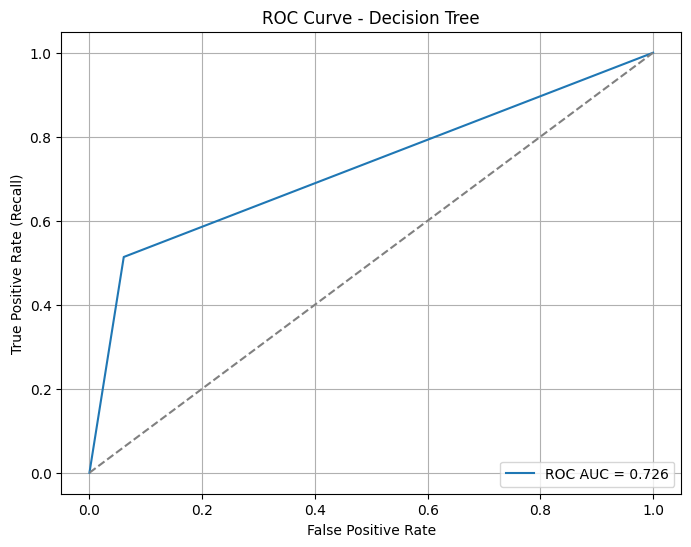

In [45]:
roc(best_dt,x_test_scaled,y_test)


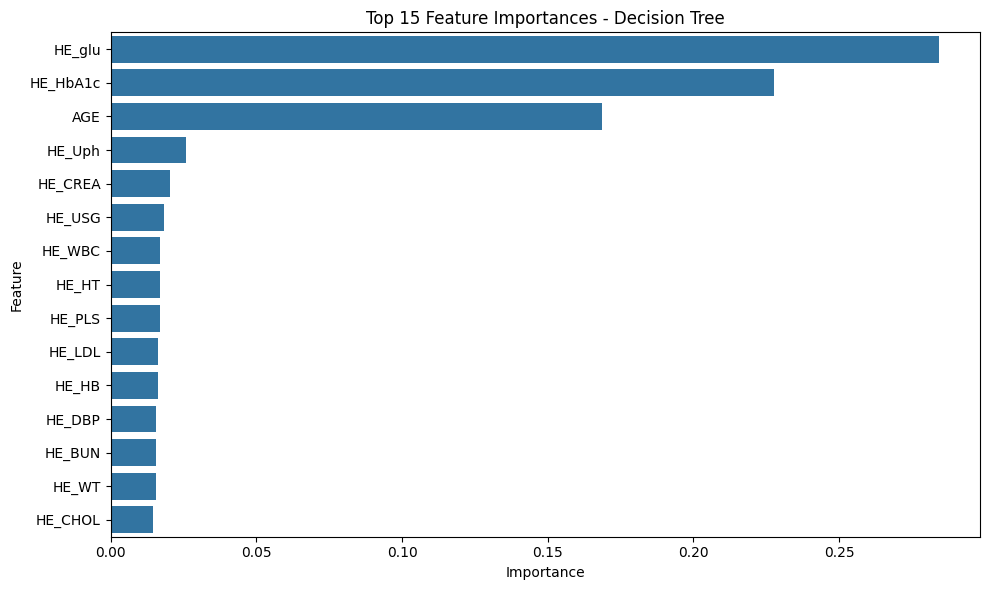

In [46]:
X = df_result.drop(['Target_HT'], axis=1)  # 입력 변수
show_feature_importance(best_dt,X)

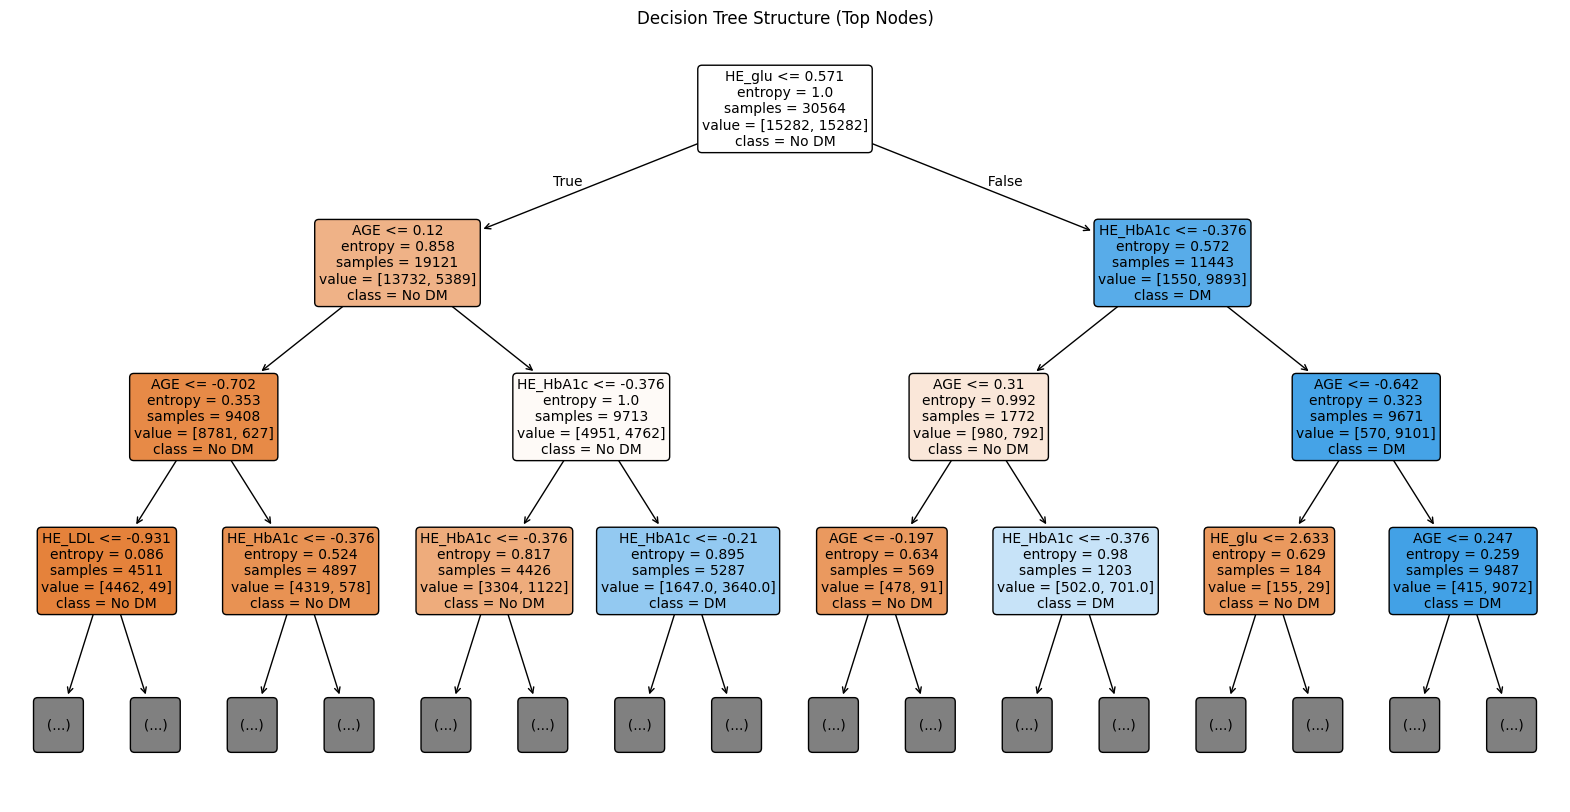

In [47]:
visualize_decision_tree(best_dt,X)

---
## Step05 : 앙상블 모델 이용하여 분류 모델 성능 비교   

> - 기본 모델: RandomForest, XGBoost, 혹은 딥러닝 기반 모델  
> - 성능 평가 지표:  
>     - Accuracy  
>     - Precision, Recall, F1-score (특히 소수 클래스 중심 평가)  
>     - AUC-ROC  

In [48]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# neg, pos = y_DM_train.value_counts()
# scale_pos_weight = neg / pos

# 모델 정의
models = {
    "tuning_Decision Tree": best_dt,
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),     #scale_pos_weight=scale_pos_weight
    "LightGBM": LGBMClassifier(random_state=42,is_unbalance=True)
}

result(models, X_resampled, x_test_scaled, y_resampled,y_test)


/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:19:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 15282, number of negative: 15282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 30564, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
################## 성능 비교 : {name} #####################


/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dibaeck/sketch/anaconda3/envs/dibk311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Accuracy,F1 Score,ROC AUC
tuning_Decision Tree,0.9196,0.3694,0.7264
Decision Tree,0.9184,0.3608,0.7205
Random Forest,0.9519,0.4839,0.9310
XGBoost,0.9592,0.5015,0.9241
LightGBM,0.9567,0.5181,0.9319


{'tuning_Decision Tree': {'Accuracy': 0.9196495619524405,
  'F1 Score': 0.3693516699410609,
  'ROC AUC': 0.7264003807361281},
 'Decision Tree': {'Accuracy': 0.9183979974968711,
  'F1 Score': 0.3607843137254902,
  'ROC AUC': 0.7205424056330598},
 'Random Forest': {'Accuracy': 0.9519399249061327,
  'F1 Score': 0.4838709677419355,
  'ROC AUC': 0.9310016112477709},
 'XGBoost': {'Accuracy': 0.9591989987484355,
  'F1 Score': 0.5015290519877675,
  'ROC AUC': 0.9241337392989639},
 'LightGBM': {'Accuracy': 0.9566958698372966,
  'F1 Score': 0.5181058495821727,
  'ROC AUC': 0.9318832103395089}}

---